## Análise de Negócios
### Analise *dos* dados de preço do petróleo brent

### Fomos contratado para uma consultoria, e nosso trabalho foi analisar os dados de preço do petróleo brent, para construir uma análise de negócios para entender a dinâmica de preços que está sendo ofertado pelos postos.

<br/>
A solicitação do nosso cliente, foi que desenvolvessemos um dashboard interativo e que gere insights relevantes para tomada de decisão. <br/>

<br/>
Além disso, solicitou que fosse desenvolvido um modelo de Machine Learning para fazer o forecasting do preço do petróleo.<br/>


1 - Trabalhamos com Dados Existentes no site do ipea <br/>
link: http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view <br/>

In [42]:
#Importando as Bibliotecas

import requests                   #Para acessar a URL
from bs4 import BeautifulSoup     #Para acessar o HTML
import pandas as pd

# URL do site IPEADATA
url = 'http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view'

# Faz uma requisicăo GET ao site e captura a resposta
response = requests.get(url)

# Verifica se a requisição foi bem sucedida
if response.status_code == 200:
    # Cria um objeto BeautifulSoup para analisar o HTML
    soup = BeautifulSoup(response.text, 'html.parser')

    # Procura pela tabela no HTML analisado (o id ou classe pode variar)
    # Inspecionar o HTML para obter o seletor correto
    table = soup.find('table', {'id': 'grd_DXMainTable'})

    # Usa ○ pandas para ler a tabela HTML diretamente para um DataFrane
    df = pd.read_html(str(table),skiprows=0)[0]

    df.columns = df.iloc[0]
    df = df.drop(0)

   # Mostra as primeiras linhas do DataFrame
    df.head()
else:
      print('Falha ao acessar a página: Status Code', response.status_code)


1.1 - **Entendimento dos Dados:**
Os preços de petróleo se estende de 1987 até 2024. É importante notar que esta série temporal é bastante longa, o que significa que ela pode conter várias tendências, sazonalidades e ciclos econômicos.

In [44]:
df

,Data,Preço - petróleo bruto - Brent (FOB)
1,12/02/2024,8388
2,09/02/2024,8358
3,08/02/2024,8301
4,07/02/2024,8118
5,06/02/2024,8046
...,...,...
11103,26/05/1987,1863
11104,25/05/1987,1860
11105,22/05/1987,1855
11106,21/05/1987,1845


In [47]:
# Renomear a coluna 'Preço - petróleo bruto - Brent (FOB)' para 'Preco'
df = df.rename(columns={'Preço - petróleo bruto - Brent (FOB)': 'preco'})
df = df.rename(columns={'Data': 'data'})

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11107 entries, 1 to 11107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    11107 non-null  object
 1   preco   11107 non-null  object
dtypes: object(2)
memory usage: 173.7+ KB


1.2 - **Pré-processamento dos Dados:** As datas devem ser tratadas como objetos de data/tempo e os preços como valores numéricos.

In [ ]:
# Converte a coluna 'Data' para datetime
df['data'] = pd.to_datetime(df['data'], format='%d/%m/%Y')
df = df[df['data'] <= pd.Timestamp('2024-01-22')]
# Ordenar o DataFrame pela coluna 'Data' de forma ascendente
df = df.sort_values(by='data', ascending=True)
# Em seguida, divida a coluna 'Preço - petróleo bruto - Brent (FOB)' por 100
df['preco'] = df['preco'].astype(float).round(2)/ 100

1.3 - **Análise de Tendência dos Preços**


<ipython-input-55-6ffd4d56ef0b>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


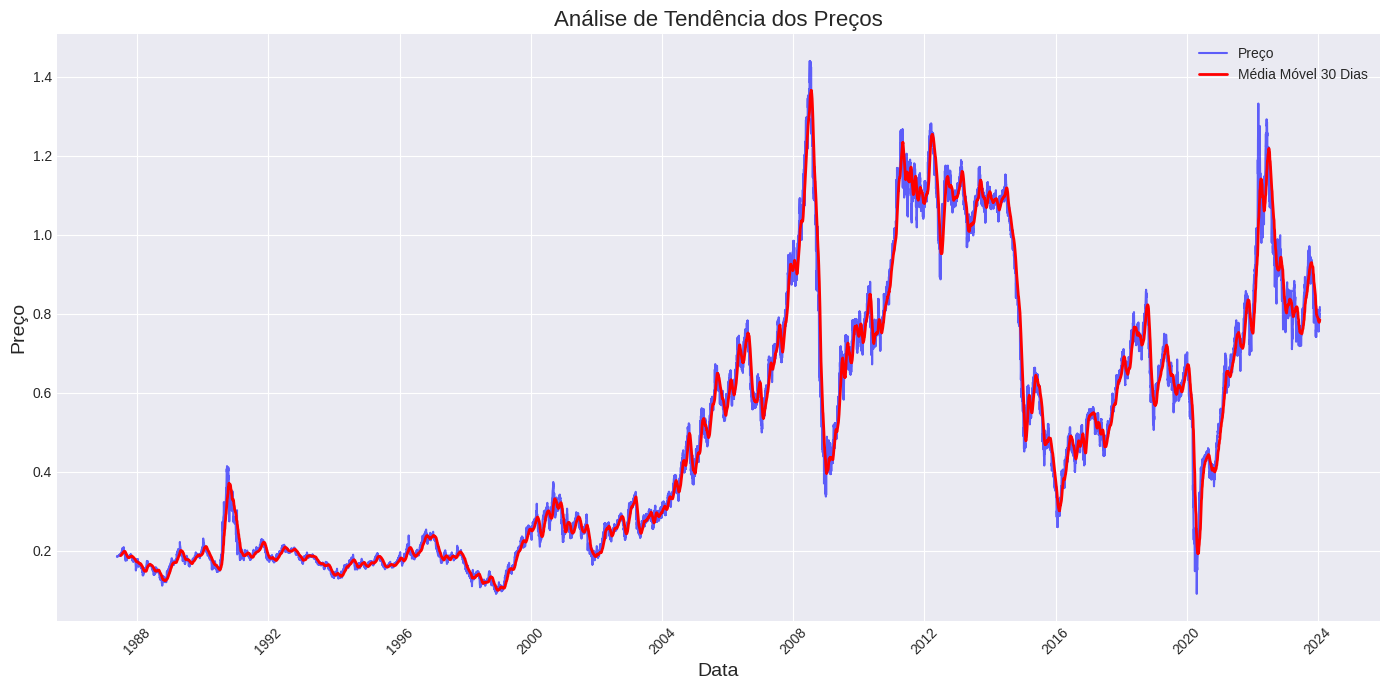

In [55]:
import matplotlib.pyplot as plt

# Configurando o estilo do gráfico
plt.style.use('seaborn-darkgrid')

# Criar uma figura e um eixo para o plot
fig, ax = plt.subplots(figsize=(14, 7))

# Plotar a série temporal de preços
ax.plot(df['data'], df['preco'], label='Preço', color='blue', alpha=0.6)

# Calcular e plotar a média móvel de 30 dias
df['Média Móvel 30 Dias'] = df['preco'].rolling(window=30).mean()
ax.plot(df['data'], df['Média Móvel 30 Dias'], label='Média Móvel 30 Dias', color='red', linewidth=2)

# Títulos e rótulos
ax.set_title('Análise de Tendência dos Preços', fontsize=16)
ax.set_xlabel('Data', fontsize=14)
ax.set_ylabel('Preço', fontsize=14)
ax.legend()

# Melhorar layout do eixo x
plt.xticks(rotation=45)

# Exibir o gráfico
plt.tight_layout()
plt.show()


No gráfico acima, a linha azul representa a série temporal dos preços, enquanto a linha vermelha indica a média móvel de 30 dias. A média móvel suaviza as flutuações de curto prazo e destaca a tendência de longo prazo dos preços.

1.4 - **Filtrar os dados para os últimos 3 anos**

<ipython-input-59-ffa4c7312682>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ultimos_3_anos['Média Móvel 30 Dias'] = data_ultimos_3_anos['preco'].rolling(window=30).mean()


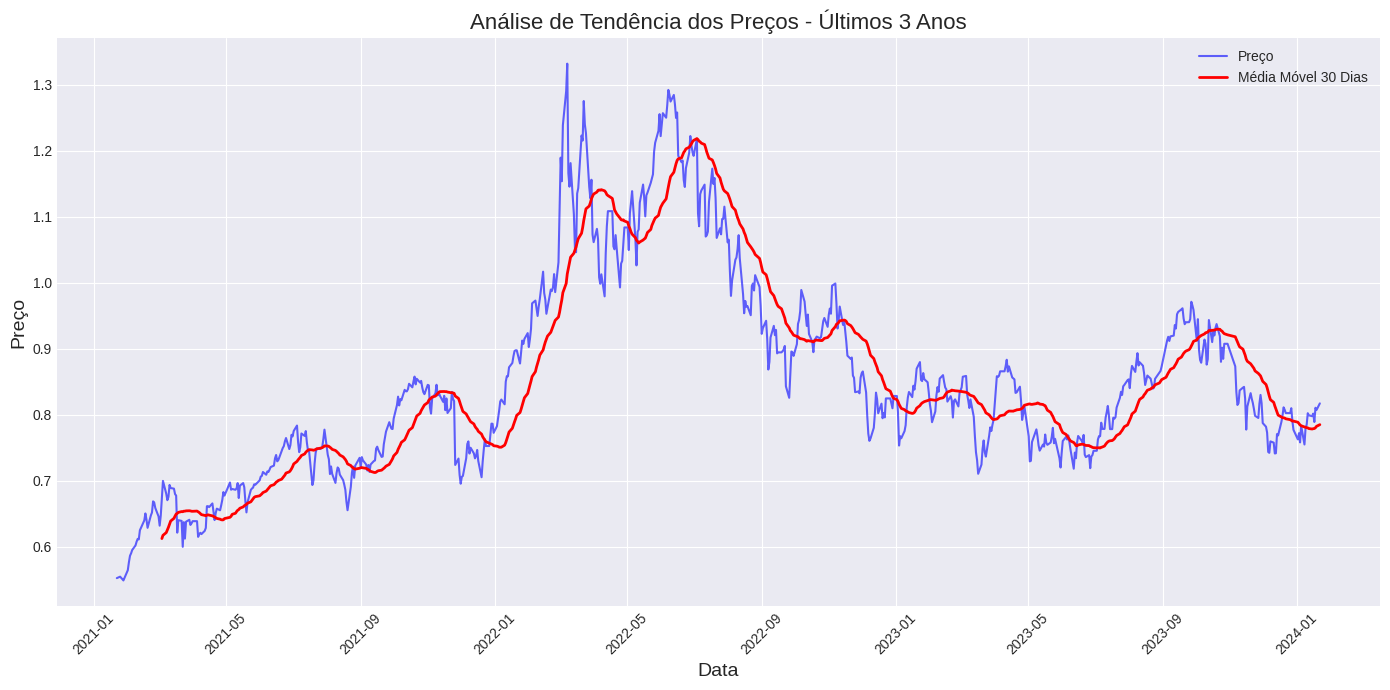

In [59]:
# Filtrar os dados para os últimos 3 anos
data_ultimos_3_anos = df[df['data'] >= pd.Timestamp(df['data'].max() - pd.DateOffset(years=3))]

# Criar uma nova figura e eixo para o plot ajustado
fig, ax = plt.subplots(figsize=(14, 7))

# Plotar a série temporal de preços para os últimos 3 anos
ax.plot(data_ultimos_3_anos['data'], data_ultimos_3_anos['preco'], label='Preço', color='blue', alpha=0.6)

# Calcular e plotar a média móvel de 30 dias para os últimos 3 anos
data_ultimos_3_anos['Média Móvel 30 Dias'] = data_ultimos_3_anos['preco'].rolling(window=30).mean()
ax.plot(data_ultimos_3_anos['data'], data_ultimos_3_anos['Média Móvel 30 Dias'], label='Média Móvel 30 Dias', color='red', linewidth=2)

# Títulos e rótulos
ax.set_title('Análise de Tendência dos Preços - Últimos 3 Anos', fontsize=16)
ax.set_xlabel('Data', fontsize=14)
ax.set_ylabel('Preço', fontsize=14)
ax.legend()

# Melhorar layout do eixo x
plt.xticks(rotation=45)

# Exibir o gráfico
plt.tight_layout()
plt.show()


O gráfico ajustado mostra a série temporal dos preços e a média móvel de 30 dias para os últimos 3 anos. Através desta visualização, é possível analisar mais detalhadamente as tendências recentes nos preços, com a média móvel suavizando as variações de curto prazo e destacando as tendências.


1.5 - **Modelo de Machine Learning**


Para criar um modelo de machine learning,utilizamos modelos ARIMA (AutoRegressive Integrated Moving Average) que é bem adequado para dados de séries temporais estacionárias ou que podem ser transformadas em estacionárias.




1.5.1 - **Análise de Estacionariedade:** Verificar se a série temporal é estacionária. Se não for, transformá-la para alcançar estacionariedade.

In [62]:
from statsmodels.tsa.stattools import adfuller

# Teste de Dickey-Fuller aumentado para verificar estacionariedade
resultado_adf = adfuller(df['preco'])

# Extrair o valor-p do teste
valor_p = resultado_adf[1]

valor_p


0.2555747004215686

1.5.2 - **Seleção de Parâmetros:** Verificar se a série temporal é estacionária. Se não for, transformá-la para alcançar estacionariedade.


In [63]:
# Diferenciar a série temporal para alcançar estacionariedade
df['preco_diff'] = df['preco'].diff().dropna()

# Teste de Dickey-Fuller aumentado na série diferenciada
resultado_adf_diff = adfuller(df['preco_diff'].dropna())

# Extrair o valor-p do teste na série diferenciada
valor_p_diff = resultado_adf_diff[1]

valor_p_diff


6.775486515242968e-30

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame

# Função para calcular o AIC para diferentes combinações de parâmetros p, d, q
def calcular_aic_para_modelo(data, p, d, q):
    try:
        model = ARIMA(data, order=(p,d,q))
        model_fit = model.fit()
        return model_fit.aic
    except:
        return float('inf')

# Parâmetros a testar
p_range = range(0, 3)
d = 1
q_range = range(0, 3)

# Calcular AIC para diferentes combinações de p, d, q
aic_values = []
parameters = []

for p in p_range:
    for q in q_range:
        aic = calcular_aic_para_modelo(df['preco'].dropna(), p, d, q)
        aic_values.append(aic)
        parameters.append((p, d, q))

# Armazenar resultados em um DataFrame
results_df = DataFrame({'parameters': parameters, 'aic': aic_values})

# Encontrar a combinação de parâmetros com o menor AIC
best_model_params = results_df.loc[results_df['aic'].idxmin()]

best_model_params


1.5.3 - **Treinar o modelo:** Treinar o modelo ARIMA com os parâmetros selecionados.

In [67]:
# Treinar o modelo ARIMA(2,1,2) com a série temporal completa
modelo_final = ARIMA(df['preco'], order=(2,1,2))
modelo_final_fit = modelo_final.fit()

# Sumário do modelo
modelo_final_sumario = modelo_final_fit.summary()

modelo_final_sumario


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  preco   No. Observations:                11092
Model:                 ARIMA(2, 1, 2)   Log Likelihood               31551.019
Date:                Fri, 16 Feb 2024   AIC                         -63092.038
Time:                        02:30:08   BIC                         -63055.468
Sample:                             0   HQIC                        -63079.723
                              - 11092                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2476      0.027      9.045      0.000       0.194       0.301
ar.L2         -0.4674      0.018    -25.861      0.000      -0.503      -0.432
ma.L1         -0.4116      0.029    -14.244      0.000      -0.468      -0.355
ma.L2          0.3260      0.022     14.606      0.000       0.282       0.370
sigma2         0.0002   1.11e-06    177.781      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):             41595.91
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               8.78   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

1.5.4 - **Validação do Modelo:** Avaliar o desempenho do modelo em um conjunto de dados de teste.

In [ ]:
# Treinar o modelo ARIMA(2,1,2) com a série temporal completa
modelo_final = ARIMA(data['preco'], order=(2,1,2))
modelo_final_fit = modelo_final.fit()

# Sumário do modelo
modelo_final_sumario = modelo_final_fit.summary()

modelo_final_sumario


1.5.5 - **Previsão:** Usar o modelo para fazer previsões diárias do preço do petróleo (10 dias).

In [69]:
# Gerar previsões para os próximos 10 dias
previsoes = modelo_final_fit.forecast(steps=10)

# Criar um DataFrame com as previsões
previsoes_df = pd.DataFrame({'Data': pd.date_range(start=df['data'].max() + pd.Timedelta(days=1), periods=10, freq='D'),
                             'Previsão de Preço': previsoes})

previsoes_df


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,Data,Previsão de Preço
11092,2024-01-23,0.814830
11093,2024-01-24,0.814068
11094,2024-01-25,0.814894
11095,2024-01-26,0.815455
11096,2024-01-27,0.815207
11097,2024-01-28,0.814884
11098,2024-01-29,0.814920
11099,2024-01-30,0.815080
11100,2024-01-31,0.815102
11101,2024-02-01,0.815033


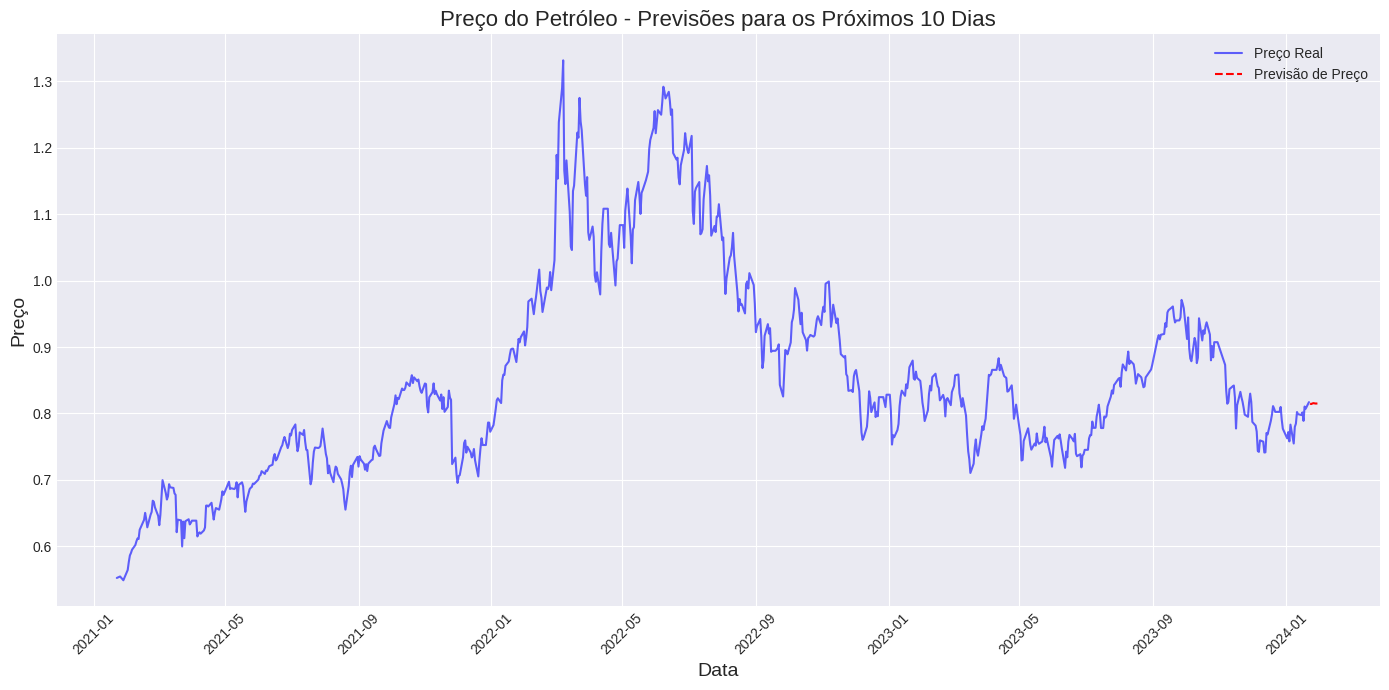

In [71]:
# Criar uma nova figura para o gráfico
fig, ax = plt.subplots(figsize=(14, 7))

# Plotar os dados reais dos últimos 3 anos
data_ultimos_3_anos = df[df['data'] >= pd.Timestamp(df['data'].max() - pd.DateOffset(years=3))]
ax.plot(data_ultimos_3_anos['data'], data_ultimos_3_anos['preco'], label='Preço Real', color='blue', alpha=0.6)

# Plotar as previsões
ax.plot(previsoes_df['Data'], previsoes_df['Previsão de Preço'], label='Previsão de Preço', color='red', linestyle='--')

# Títulos e rótulos
ax.set_title('Preço do Petróleo - Previsões para os Próximos 10 Dias', fontsize=16)
ax.set_xlabel('Data', fontsize=14)
ax.set_ylabel('Preço', fontsize=14)
ax.legend()

# Melhorar layout do eixo x
plt.xticks(rotation=45)

# Exibir o gráfico
plt.tight_layout()
plt.show()


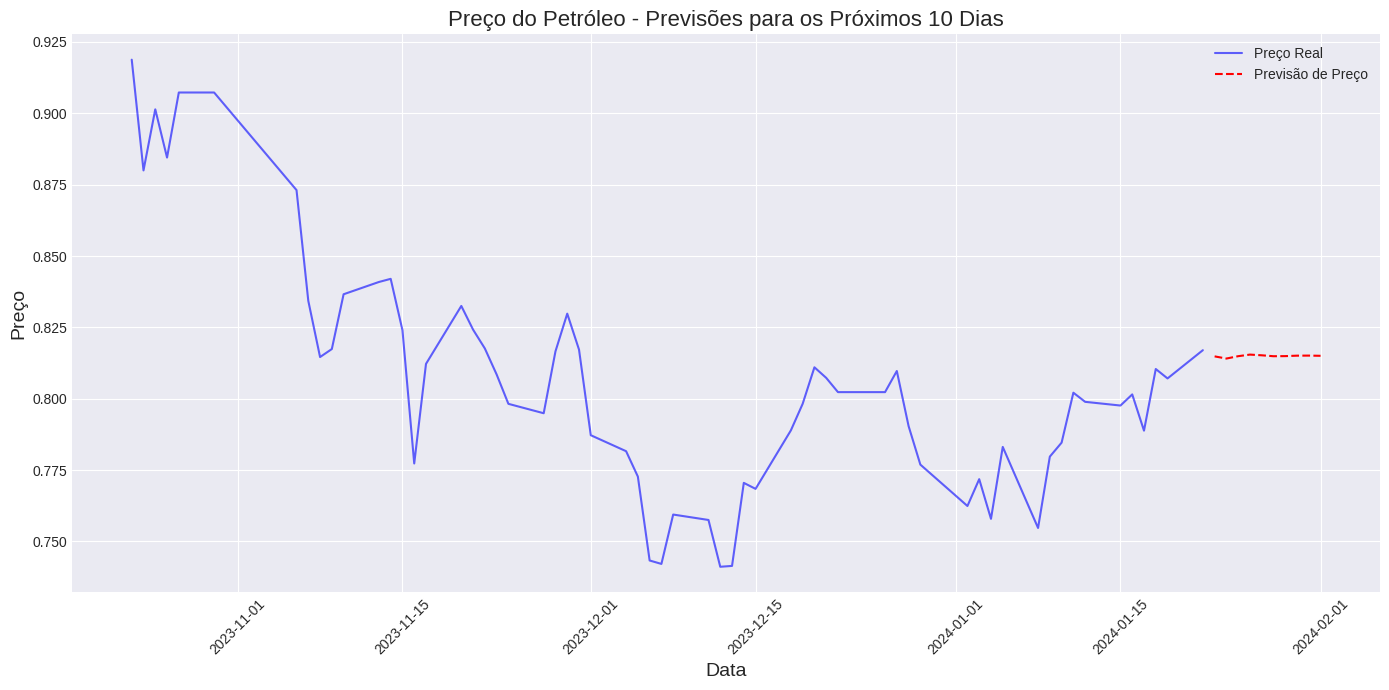

In [73]:
# Filtrar os dados para os últimos 3 meses
data_ultimos_3_meses = df[df['data'] >= pd.Timestamp(df['data'].max() - pd.DateOffset(months=3))]

# Criar uma nova figura e eixo para o plot
fig, ax = plt.subplots(figsize=(14, 7))

# Plotar a série temporal de preços para os últimos 3 meses
ax.plot(data_ultimos_3_meses['data'], data_ultimos_3_meses['preco'], label='Preço Real', color='blue', alpha=0.6)

# Plotar as previsões
ax.plot(previsoes_df['Data'], previsoes_df['Previsão de Preço'], label='Previsão de Preço', color='red', linestyle='--')

# Títulos e rótulos
ax.set_title('Preço do Petróleo - Previsões para os Próximos 10 Dias', fontsize=16)
ax.set_xlabel('Data', fontsize=14)
ax.set_ylabel('Preço', fontsize=14)
ax.legend()

# Melhorar layout do eixo x
plt.xticks(rotation=45)

# Exibir o gráfico
plt.tight_layout()
plt.show()


Essas previsões fornecem uma estimativa de como o preço do petróleo pode se comportar nos próximos 10 dias, com base nos padrões históricos capturados pelo modelo. Como sempre, é importante considerar que previsões de séries temporais estão sujeitas a incertezas e podem ser influenciadas por eventos externos não incluídos no modelo.